# Iris Flower Classification (Code)

# Header

In [42]:
import pandas as pd
import dagshub
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from ydata_profiling import ProfileReport

def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Exception as e:
        print(e)

    return conn


def create_table(conn, create_table_sql, drop_table_name=None):
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Exception as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Exception as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

db_name = 'Iris_Normalized.db'

In [41]:

dagshub.init(repo_owner='Vedclove', repo_name='EAS-Iris', mlflow=True)

Initialized MLflow to track repo "Vedclove/EAS-Iris"

Repository Vedclove/EAS-Iris initialized!

# Normalize Data

In [14]:
def read_csv(filename):
    flower_data = []
    flower_metric = []
    with open(filename, 'r') as file:
        lines = file.readlines()
    
    for line in lines:
        flower_metric.append(line.strip().split(',')[0:5])

    for line in lines:
        flower_data.append(line.strip().split(',')[0:6:5])
    
    return (flower_metric, flower_data)

flower_metric, flower_data = read_csv('Iris.csv')

In [15]:
flower_data[0:5]

[['Id', 'Species'],
 ['1', 'Iris-setosa'],
 ['2', 'Iris-setosa'],
 ['3', 'Iris-setosa'],
 ['4', 'Iris-setosa']]

In [16]:
flower_metric[0:5]

[['Id', 'SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm'],
 ['1', '5.1', '3.5', '1.4', '0.2'],
 ['2', '4.9', '3.0', '1.4', '0.2'],
 ['3', '4.7', '3.2', '1.3', '0.2'],
 ['4', '4.6', '3.1', '1.5', '0.2']]

## Table 1 - Flower Attribute Info

In [17]:
conn = create_connection(db_name)
cur = conn.cursor()
sql_create_table_flr_attr = ''' CREATE TABLE IF NOT EXISTS [FlowerAttributes] (
                                ID INTEGER NOT NULL PRIMARY KEY,
                                SepalLengthCm FLOAT NOT NULL,
                                SepalWidthCm FLOAT NOT NULL,
                                PetalLengthCm FLOAT NOT NULL,
                                PetalWidthCm FLOAT NOT NULL);
                                '''

create_table(conn,sql_create_table_flr_attr, True)

In [18]:
conn = create_connection(db_name)
cur = conn.cursor()
flr_attr_sql_insert = ''' INSERT OR IGNORE INTO FlowerAttributes (
                          SepalLengthCm, SepalWidthCm, PetalLengthCm, PetalWidthCm) VALUES (?,?,?,?);
                        '''

flower_attribute = []

for flower in flower_metric[1:]:
  sepal_len = flower[0]
  sepal_wid = flower[1]
  petal_len = flower[2]
  petal_wid = flower[3]
  flower_attribute.append((sepal_len,sepal_wid,petal_len, petal_wid))

cur.executemany(flr_attr_sql_insert, flower_attribute)
conn.commit()
conn.close()

In [19]:
conn = create_connection(db_name)
sql = ''' SELECT * FROM FlowerAttributes '''
pd.read_sql_query(sql,conn)

,ID,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,1,1.0,5.1,3.5,1.4
1,2,2.0,4.9,3.0,1.4
2,3,3.0,4.7,3.2,1.3
3,4,4.0,4.6,3.1,1.5
4,5,5.0,5.0,3.6,1.4
...,...,...,...,...,...
145,146,146.0,6.7,3.0,5.2
146,147,147.0,6.3,2.5,5.0
147,148,148.0,6.5,3.0,5.2
148,149,149.0,6.2,3.4,5.4


## Table 2 - Flower Name

In [20]:
conn = create_connection(db_name)
cur = conn.cursor()
sql_create_table_flr_attr = ''' CREATE TABLE IF NOT EXISTS [FlowerNames] (
                                ID INTEGER NOT NULL PRIMARY KEY,
                                Species TEXT NOT NULL);
                                '''

create_table(conn,sql_create_table_flr_attr, True)

In [21]:
conn = create_connection(db_name)
cur = conn.cursor()
flr_attr_sql_insert = ''' INSERT INTO FlowerNames (
                          Species) VALUES (?);
                        '''

flower_species = []

for flower in flower_data[1:]:
  species_name = flower[1]
  flower_species.append((species_name,))

cur.executemany(flr_attr_sql_insert, flower_species)
conn.commit()
conn.close()

In [22]:
conn = create_connection(db_name)
sql = ''' SELECT * FROM FlowerNames '''
sql_drop = ''' DROP TABLE FlowerNames '''
#execute_sql_statement(sql_drop,conn)
pd.read_sql_query(sql,conn)

,ID,Species
0,1,Iris-setosa
1,2,Iris-setosa
2,3,Iris-setosa
3,4,Iris-setosa
4,5,Iris-setosa
...,...,...
145,146,Iris-virginica
146,147,Iris-virginica
147,148,Iris-virginica
148,149,Iris-virginica


## Extract Data into DataFrame

In [23]:
conn = create_connection(db_name)
sql = ''' SELECT FA.ID, FA.SepalLengthCm, FA.SepalWidthCm, FA.PetalLengthCm, FA.PetalWidthCm, FN.Species FROM FlowerAttributes as FA
        INNER JOIN FlowerNames as FN
        ON FA.ID = FN.ID; '''

df = pd.read_sql_query(sql, conn)

In [24]:
df

,ID,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,1.0,5.1,3.5,1.4,Iris-setosa
1,2,2.0,4.9,3.0,1.4,Iris-setosa
2,3,3.0,4.7,3.2,1.3,Iris-setosa
3,4,4.0,4.6,3.1,1.5,Iris-setosa
4,5,5.0,5.0,3.6,1.4,Iris-setosa
...,...,...,...,...,...,...
145,146,146.0,6.7,3.0,5.2,Iris-virginica
146,147,147.0,6.3,2.5,5.0,Iris-virginica
147,148,148.0,6.5,3.0,5.2,Iris-virginica
148,149,149.0,6.2,3.4,5.4,Iris-virginica


# Stratification and Data Train/Test split

## Exploring data and Define Train/Test data

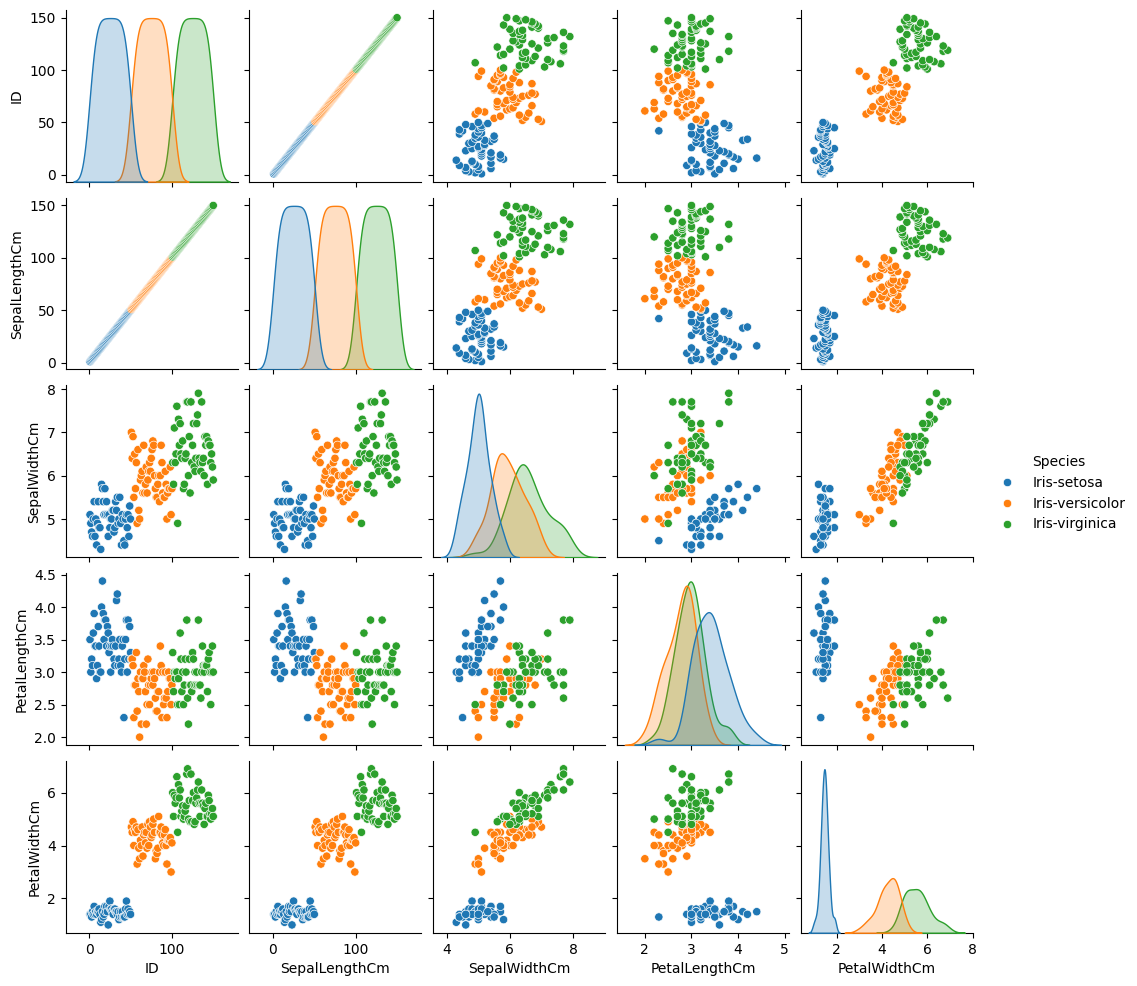

In [25]:
sns.pairplot(df, hue='Species', height=2)
plt.show()

In [26]:
# Checking distribution of the species over the entire dataset
species_counts = df['Species'].value_counts()
print("Species distribution in the entire dataset:")
print(species_counts)

Species distribution in the entire dataset:
Species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64


In [27]:
X = df.drop(columns=['Species'])
y = df['Species']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the distribution in train and test sets
train_distribution = pd.Series(y_train).value_counts()
test_distribution = pd.Series(y_test).value_counts()

print("\nSpecies distribution in the TRAINING set:")
print(train_distribution)

print("\nSpecies distribution in the TESTING set:")
print(test_distribution)


Species distribution in the TRAINING set:
Species
Iris-setosa        40
Iris-virginica     40
Iris-versicolor    40
Name: count, dtype: int64

Species distribution in the TESTING set:
Species
Iris-setosa        10
Iris-virginica     10
Iris-versicolor    10
Name: count, dtype: int64


## Data Exploration using yprofile and correlation matrix

In [28]:
# Generate a profile report using ydata-profiling
profile = ProfileReport(df, title="Iris Dataset Profiling Report", explorative=True)
profile.to_notebook_iframe()  # Display the report in a notebook (or save it to HTML if needed)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [29]:
# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing Values:")
print(missing_values)

# Check for capped values (e.g., outliers or unusual distributions)
print("\nSummary Statistics:")
print(df.describe())


Missing Values:
ID               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

Summary Statistics:
               ID  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
count  150.000000     150.000000    150.000000     150.000000    150.000000
mean    75.500000      75.500000      5.843333       3.054000      3.758667
std     43.445368      43.445368      0.828066       0.433594      1.764420
min      1.000000       1.000000      4.300000       2.000000      1.000000
25%     38.250000      38.250000      5.100000       2.800000      1.600000
50%     75.500000      75.500000      5.800000       3.000000      4.350000
75%    112.750000     112.750000      6.400000       3.300000      5.100000
max    150.000000     150.000000      7.900000       4.400000      6.900000


# EDA

## Y DATA PROFILING


In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport

# Profile Report
profile = ProfileReport(df, title="Iris Dataset Profile Report", explorative=True)
profile.to_file("iris_profile_report.html")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## CORRELATION MATRIX

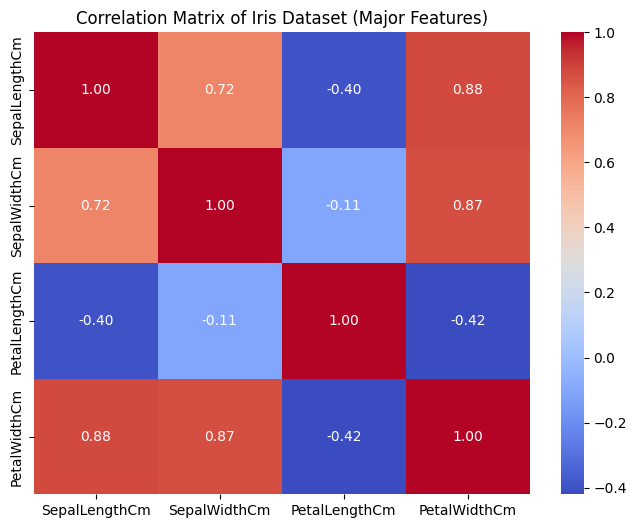

In [31]:
%matplotlib inline
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Display inline for Jupyter Notebook
%matplotlib inline

# Select features and calculate the correlation matrix
features = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
correlation_matrix = df[features].corr()

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Iris Dataset (Major Features)")
plt.show()


## OUTLIER DETECTION

In [32]:
import pandas as pd

# Define a function to detect outliers using IQR
def find_outliers_iqr(data, features):
    outliers = {}
    for feature in features:
        Q1 = data[feature].quantile(0.25)  # First quartile
        Q3 = data[feature].quantile(0.75)  # Third quartile
        IQR = Q3 - Q1  # Interquartile Range
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[feature] = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]
    return outliers

# Specify the features to check for outliers
features = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']

# Detect outliers
outliers = find_outliers_iqr(df, features)

# Display the outliers
for feature, outlier_data in outliers.items():
    print(f"Outliers in {feature}:")
    print(outlier_data)

Outliers in SepalLengthCm:
Empty DataFrame
Columns: [ID, SepalLengthCm, SepalWidthCm, PetalLengthCm, PetalWidthCm, Species]
Index: []
Outliers in SepalWidthCm:
Empty DataFrame
Columns: [ID, SepalLengthCm, SepalWidthCm, PetalLengthCm, PetalWidthCm, Species]
Index: []
Outliers in PetalLengthCm:
    ID  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  \
15  16           16.0           5.7            4.4           1.5   
32  33           33.0           5.2            4.1           1.5   
33  34           34.0           5.5            4.2           1.4   
60  61           61.0           5.0            2.0           3.5   

            Species  
15      Iris-setosa  
32      Iris-setosa  
33      Iris-setosa  
60  Iris-versicolor  
Outliers in PetalWidthCm:
Empty DataFrame
Columns: [ID, SepalLengthCm, SepalWidthCm, PetalLengthCm, PetalWidthCm, Species]
Index: []


## CAPPING OUTLIER

In [33]:
import pandas as pd

# Define a function to cap outliers using IQR
def cap_outliers_iqr(data, feature):
    Q1 = data[feature].quantile(0.25)  # First quartile
    Q3 = data[feature].quantile(0.75)  # Third quartile
    IQR = Q3 - Q1  # Interquartile Range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Replace outliers with bounds
    data[feature] = data[feature].apply(
        lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x)
    )
    return data

# Cap outliers in 'PetalLengthCm'
df = cap_outliers_iqr(df, 'PetalLengthCm')

# Display the updated DataFrame
print("Updated DataFrame after capping outliers in PetalLengthCm:")
print(df)


Updated DataFrame after capping outliers in PetalLengthCm:
      ID  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  \
0      1            1.0           5.1            3.5           1.4   
1      2            2.0           4.9            3.0           1.4   
2      3            3.0           4.7            3.2           1.3   
3      4            4.0           4.6            3.1           1.5   
4      5            5.0           5.0            3.6           1.4   
..   ...            ...           ...            ...           ...   
145  146          146.0           6.7            3.0           5.2   
146  147          147.0           6.3            2.5           5.0   
147  148          148.0           6.5            3.0           5.2   
148  149          149.0           6.2            3.4           5.4   
149  150          150.0           5.9            3.0           5.1   

            Species  
0       Iris-setosa  
1       Iris-setosa  
2       Iris-setosa  
3       Iris

In [34]:
df.head()

,ID,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,1.0,5.1,3.5,1.4,Iris-setosa
1,2,2.0,4.9,3.0,1.4,Iris-setosa
2,3,3.0,4.7,3.2,1.3,Iris-setosa
3,4,4.0,4.6,3.1,1.5,Iris-setosa
4,5,5.0,5.0,3.6,1.4,Iris-setosa


# Experiment 1 

### LABEL ENCODING

In [35]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'Species' column
df['Species_encoded'] = label_encoder.fit_transform(df['Species'])

# Display the mapping of species to encoded values
species_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Species Mapping:", species_mapping)

# Display the updated DataFrame
print(df.head())


Species Mapping: {'Iris-setosa': np.int64(0), 'Iris-versicolor': np.int64(1), 'Iris-virginica': np.int64(2)}
   ID  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species  \
0   1            1.0           5.1            3.5           1.4  Iris-setosa   
1   2            2.0           4.9            3.0           1.4  Iris-setosa   
2   3            3.0           4.7            3.2           1.3  Iris-setosa   
3   4            4.0           4.6            3.1           1.5  Iris-setosa   
4   5            5.0           5.0            3.6           1.4  Iris-setosa   

   Species_encoded  
0                0  
1                0  
2                0  
3                0  
4                0  


### StandardScaleR

In [36]:
from sklearn.preprocessing import StandardScaler

# Select the numerical features to standardize
numerical_features = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']

# Initialize the StandardScaler
scaler = StandardScaler()

# Standardize the numerical features
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Display the standardized dataset
print(df.head())


   ID  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species  \
0   1      -1.720542     -0.900681       1.065722     -1.341272  Iris-setosa   
1   2      -1.697448     -1.143017      -0.120170     -1.341272  Iris-setosa   
2   3      -1.674353     -1.385353       0.354187     -1.398138  Iris-setosa   
3   4      -1.651258     -1.506521       0.117008     -1.284407  Iris-setosa   
4   5      -1.628164     -1.021849       1.302901     -1.341272  Iris-setosa   

   Species_encoded  
0                0  
1                0  
2                0  
3                0  
4                0  


### CHECKING SKEWNESS 

In [37]:
# Check skewness of numerical features
skewness = df[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']].skew()
print(skewness)


SepalLengthCm    9.569869e-17
SepalWidthCm     3.149110e-01
PetalLengthCm    2.070941e-01
PetalWidthCm    -2.744643e-01
dtype: float64


EXPLANATION OF THE SKEWNESS 
Based on the skewness values you provided:

1. **Interpretation of Skewness**:
   - **SepalLengthCm**: \( 9.57 \times 10^{-17} \) (essentially 0) — Perfectly symmetric, no skewness.
   - **SepalWidthCm**: \( 0.315 \) — Slightly skewed, but well within acceptable limits.
   - **PetalLengthCm**: \( 0.207 \) — Slightly skewed, but well within acceptable limits.
   - **PetalWidthCm**: \( -0.274 \) — Slightly negatively skewed, but not extreme.

2. **Thresholds for Skewness**:
   - **Highly Skewed**: Skewness > 1 or < -1.
   - **Moderately Skewed**: Skewness between 0.5 and 1 (or -0.5 and -1).
   - **Symmetric/Minimal Skewness**: Skewness between -0.5 and 0.5.

3. **Do You Need Log Transformation?**
   - No. None of your features exhibit high or moderate skewness. All skewness values fall within the range of -0.5 to 0.5, which indicates symmetric data or minimal skewness.

4. **Conclusion**:
   - Log transformation is **not necessary** for your dataset as the skewness is minimal, and applying it might distort the already well-distributed features.

---



## Logistic Regression using 3 fold without HyperTuning

In [38]:
df.tail()

,ID,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,Species_encoded
145,146,1.628164,1.038005,-0.120170,0.819624,Iris-virginica,2
146,147,1.651258,0.553333,-1.306063,0.705893,Iris-virginica,2
147,148,1.674353,0.795669,-0.120170,0.819624,Iris-virginica,2
148,149,1.697448,0.432165,0.828544,0.933356,Iris-virginica,2
149,150,1.720542,0.068662,-0.120170,0.762759,Iris-virginica,2


In [40]:
import numpy as np
import mlflow
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# Split features and target
X = df[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']].values
y = df['Species_encoded'].values

# Initialize Logistic Regression model
log_reg = LogisticRegression(random_state=42, max_iter=500)

# Perform 3-fold cross-validation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
y_pred = cross_val_predict(log_reg, X, y, cv=skf)

# Train model and evaluate
accuracy = accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred, average='weighted')
conf_matrix = confusion_matrix(y, y_pred)

for i in range(3):
    TP = conf_matrix[i, i]  # True Positives (diagonal element)
    
    # False Positives (sum of column - TP)
    FP = conf_matrix[:, i].sum() - TP
    
    # False Negatives (sum of row - TP)
    FN = conf_matrix[i, :].sum() - TP
    
    # True Negatives (sum of all elements except row and column of class i)
    TN = conf_matrix.sum() - (TP + FP + FN)


mlflow.set_experiment('Experiment-1')
# Log F1 score and Accuracy
with mlflow.start_run():
    # Log model parameters
    mlflow.log_param("model", "LogisticRegression")
    mlflow.log_param("random_state", 42)
    mlflow.log_param("max_iter", 500)
    mlflow.log_param("cv_splits", 3)

    # Log metrics
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("TP", TP)
    mlflow.log_metric("TN", TN)
    mlflow.log_metric("FN", FN)
    mlflow.log_metric("FP", FP)

    mlflow.log_param("confusion_matrix", conf_matrix.tolist())

    mlflow.end_run()

🏃 View run amusing-toad-548 at: https://dagshub.com/Vedclove/EAS-Iris.mlflow/#/experiments/3/runs/fb7655eee3f04d8383b9751d707e6e01
🧪 View experiment at: https://dagshub.com/Vedclove/EAS-Iris.mlflow/#/experiments/3


## Logistic Regression using 3 fold with HyperTuning

In [30]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Define parameter grid for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'lbfgs'],  # Solvers to try
    'max_iter': [300, 600, 900]  # Iterations
}

# Initialize the model
log_reg = LogisticRegression(random_state=42)

# Define Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=skf, scoring='accuracy', verbose=1)
grid_search.fit(X, y)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Results on the whole training data
y_pred = best_model.predict(X)

# Calculate mean/std for cross-validation results
cv_results = grid_search.cv_results_
mean_accuracy = np.mean(cv_results['mean_test_score'])
std_accuracy = np.std(cv_results['mean_test_score'])

# Accuracy metrics
accuracy = accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred, average='weighted')
conf_matrix = confusion_matrix(y, y_pred)


mlflow.set_experiment('Experiment-1')
# Log F1 score and Accuracy
with mlflow.start_run():
    # Log model parameters
    mlflow.log_param("model", "LogisticRegression")
    mlflow.log_param("random_state", 42)
    mlflow.log_param("max_iter", 500)
    mlflow.log_param("cv_splits", 3)

    # Log metrics
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("TP", TP)
    mlflow.log_metric("TN", TN)
    mlflow.log_metric("FN", FN)
    mlflow.log_metric("FP", FP)

    mlflow.log_param("confusion_matrix", conf_matrix.tolist())

    mlflow.end_run()

Fitting 3 folds for each of 30 candidates, totalling 90 fits
🏃 View run unruly-squid-827 at: https://dagshub.com/Vedclove/EAS-Iris.mlflow/#/experiments/3/runs/88dafda1352a4f019e8faaa9cd15c5b2
🧪 View experiment at: https://dagshub.com/Vedclove/EAS-Iris.mlflow/#/experiments/3


# Experiment 2

## RidgeClassifier

In [31]:
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import numpy as np

# Define parameter grid for Ridge Classifier
param_grid_ridge = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],  # Regularization strength
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'max_iter': [1000,5000]
}

# Initialize Ridge Classifier
ridge_clf = RidgeClassifier()

# Stratified K-Fold Cross Validation
skf_ridge = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# GridSearchCV for Ridge Classifier
grid_search_ridge = GridSearchCV(estimator=ridge_clf, param_grid=param_grid_ridge, cv=skf_ridge, scoring='accuracy', verbose=1)
grid_search_ridge.fit(X, y)

# Best model and parameters
best_ridge_model = grid_search_ridge.best_estimator_
best_ridge_params = grid_search_ridge.best_params_

# Results on the whole training data
y_ridge_pred = best_ridge_model.predict(X)

# Calculate mean/std for cross-validation results
cv_results_ridge = grid_search_ridge.cv_results_
mean_ridge_accuracy = np.mean(cv_results_ridge['mean_test_score'])
std_ridge_accuracy = np.std(cv_results_ridge['mean_test_score'])

# Accuracy metrics
ridge_accuracy = accuracy_score(y, y_ridge_pred)
ridge_f1 = f1_score(y, y_ridge_pred, average='weighted')
ridge_conf_matrix = confusion_matrix(y, y_ridge_pred)

for i in range(3):
    TP = ridge_conf_matrix[i, i]  # True Positives (diagonal element)
    
    # False Positives (sum of column - TP)
    FP = ridge_conf_matrix[:, i].sum() - TP
    
    # False Negatives (sum of row - TP)
    FN = ridge_conf_matrix[i, :].sum() - TP
    
    # True Negatives (sum of all elements except row and column of class i)
    TN = ridge_conf_matrix.sum() - (TP + FP + FN)

mlflow.set_experiment('Experiment-2')

# Log F1 score and Accuracy
with mlflow.start_run():
    # Log model parameters
    mlflow.log_param("model", "RidgeClassifier")
    mlflow.log_param("random_state", 42)
    mlflow.log_param("max_iter", 5000)
    mlflow.log_param("cv_splits", 3)

    # Log metrics
    mlflow.log_metric("accuracy", ridge_accuracy)
    mlflow.log_metric("f1_score", ridge_f1)
    mlflow.log_metric("TP", TP)
    mlflow.log_metric("TN", TN)
    mlflow.log_metric("FN", FN)
    mlflow.log_metric("FP", FP)

    # Log Confusion Matrix    
    mlflow.log_param("confusion_matrix", ridge_conf_matrix.tolist())


Fitting 3 folds for each of 70 candidates, totalling 210 fits
🏃 View run upset-eel-659 at: https://dagshub.com/Vedclove/EAS-Iris.mlflow/#/experiments/4/runs/7f364ba3ed7444eb9393ce50d85da473
🧪 View experiment at: https://dagshub.com/Vedclove/EAS-Iris.mlflow/#/experiments/4


## RandomForest

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import numpy as np

# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],       # Number of trees
    'max_depth': [None, 10, 20, 30],      # Maximum depth of trees
    'min_samples_split': [2, 5, 10],      # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],        # Minimum samples in a leaf node
    'bootstrap': [True, False]            # Whether to use bootstrap sampling
}

# Initialize Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)

# Stratified K-Fold Cross Validation
skf_rf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# GridSearchCV for Random Forest Classifier
grid_search_rf = GridSearchCV(estimator=rf_clf, param_grid=param_grid_rf, cv=skf_rf, scoring='accuracy', verbose=1)
grid_search_rf.fit(X, y)

# Best model and parameters
best_rf_model = grid_search_rf.best_estimator_
best_rf_params = grid_search_rf.best_params_

# Results on the whole training data
y_rf_pred = best_rf_model.predict(X)

# Calculate mean/std for cross-validation results
cv_results_rf = grid_search_rf.cv_results_
mean_rf_accuracy = np.mean(cv_results_rf['mean_test_score'])
std_rf_accuracy = np.std(cv_results_rf['mean_test_score'])

# Accuracy metrics
rf_accuracy = accuracy_score(y, y_rf_pred)
rf_f1 = f1_score(y, y_rf_pred, average='weighted')
rf_conf_matrix = confusion_matrix(y, y_rf_pred)

for i in range(3):
    TP = rf_conf_matrix[i, i]  # True Positives (diagonal element)
    
    # False Positives (sum of column - TP)
    FP = rf_conf_matrix[:, i].sum() - TP
    
    # False Negatives (sum of row - TP)
    FN = rf_conf_matrix[i, :].sum() - TP
    
    # True Negatives (sum of all elements except row and column of class i)
    TN = rf_conf_matrix.sum() - (TP + FP + FN)

mlflow.set_experiment('Experiment-2')

# Log F1 score and Accuracy
with mlflow.start_run():
    # Log model parameters
    mlflow.log_param("model", "RandomForest")
    mlflow.log_param("random_state", 42)
    mlflow.log_param("cv_splits", 3)

    # Log metrics
    mlflow.log_metric("accuracy", rf_accuracy)
    mlflow.log_metric("f1_score", rf_f1)
    mlflow.log_metric("TP", TP)
    mlflow.log_metric("TN", TN)
    mlflow.log_metric("FN", FN)
    mlflow.log_metric("FP", FP)

    # Log Confusion Matrix    
    mlflow.log_param("confusion_matrix", rf_conf_matrix.tolist())


Fitting 3 folds for each of 216 candidates, totalling 648 fits
🏃 View run enchanting-asp-270 at: https://dagshub.com/Vedclove/EAS-Iris.mlflow/#/experiments/4/runs/08b84354392748dfa72b42a5b2c0ab37
🧪 View experiment at: https://dagshub.com/Vedclove/EAS-Iris.mlflow/#/experiments/4


In [33]:
df

,ID,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,Species_encoded
0,1,-1.720542,-0.900681,1.065722,-1.341272,Iris-setosa,0
1,2,-1.697448,-1.143017,-0.120170,-1.341272,Iris-setosa,0
2,3,-1.674353,-1.385353,0.354187,-1.398138,Iris-setosa,0
3,4,-1.651258,-1.506521,0.117008,-1.284407,Iris-setosa,0
4,5,-1.628164,-1.021849,1.302901,-1.341272,Iris-setosa,0
...,...,...,...,...,...,...,...
145,146,1.628164,1.038005,-0.120170,0.819624,Iris-virginica,2
146,147,1.651258,0.553333,-1.306063,0.705893,Iris-virginica,2
147,148,1.674353,0.795669,-0.120170,0.819624,Iris-virginica,2
148,149,1.697448,0.432165,0.828544,0.933356,Iris-virginica,2


## XGBOOST

In [34]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your data is in X (features) and y (target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the XGBClassifier
xgb_clf = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Train the model
xgb_clf.fit(X_train, y_train)

# Predictions
y_pred = xgb_clf.predict(X_test)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

for i in range(3):
    TP = conf_matrix[i, i]  # True Positives (diagonal element)
    
    # False Positives (sum of column - TP)
    FP = conf_matrix[:, i].sum() - TP
    
    # False Negatives (sum of row - TP)
    FN = conf_matrix[i, :].sum() - TP
    
    # True Negatives (sum of all elements except row and column of class i)
    TN = conf_matrix.sum() - (TP + FP + FN)

mlflow.set_experiment('Experiment-2')

# Log F1 score and Accuracy
with mlflow.start_run():
    # Log model parameters
    mlflow.log_param("model", "XGBoost")
    mlflow.log_param("random_state", 42)
    mlflow.log_param("cv_splits", 3)

    # Log metrics
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("TP", TP)
    mlflow.log_metric("TN", TN)
    mlflow.log_metric("FN", FN)
    mlflow.log_metric("FP", FP)

    # Log Confusion Matrix    
    mlflow.log_param("confusion_matrix", conf_matrix.tolist())


🏃 View run selective-donkey-426 at: https://dagshub.com/Vedclove/EAS-Iris.mlflow/#/experiments/4/runs/86707033563b40629ffa9974fc8b4dc6
🧪 View experiment at: https://dagshub.com/Vedclove/EAS-Iris.mlflow/#/experiments/4


# Experiment 3 :- Feature engineering and attribute combination. 

In [35]:
import pandas as pd
import numpy as np

# Assuming your original dataframe is 'df'
df_new = df.copy()

# 1. Create interaction features
df_new['SepalRatio'] = df_new['SepalLengthCm'] / df_new['SepalWidthCm']
df_new['PetalRatio'] = df_new['PetalLengthCm'] / df_new['PetalWidthCm']
df_new['SepalPetalArea'] = df_new['SepalLengthCm'] * df_new['PetalLengthCm']

# 2. Create polynomial features (for example, square the PetalLengthCm)
df_new['PetalLengthSquared'] = df_new['PetalLengthCm'] ** 2

# 3. Create binning features
df_new['SepalLengthBin'] = pd.cut(df_new['SepalLengthCm'], bins=[0, 4, 5, 6, 8], labels=['Short', 'Medium', 'Long', 'Very Long'])
df_new['PetalWidthBin'] = pd.cut(df_new['PetalWidthCm'], bins=[0, 1.2, 2.0, 3.0], labels=['Thin', 'Medium', 'Wide'])

# 4. Apply log transformation (e.g., on highly skewed features like PetalLengthCm)
df_new['Log_PetalLengthCm'] = np.log1p(df_new['PetalLengthCm'])

# 5. Create additional features based on domain knowledge or data insight
df_new['SepalSize'] = df_new['SepalLengthCm'] * df_new['SepalWidthCm']  # Sepal area as a new feature

df_new.to_csv('artifacts/featureengg.csv', index=False)

mlflow.set_experiment('Experiment-3')

with mlflow.start_run():
    mlflow.log_artifact('artifacts/featureengg.csv')


/Users/vedclove/Documents/Kaam-Dhanda/EAS/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


🏃 View run blushing-donkey-586 at: https://dagshub.com/Vedclove/EAS-Iris.mlflow/#/experiments/5/runs/0d4136b2db0843bdb9db517564040c5d
🧪 View experiment at: https://dagshub.com/Vedclove/EAS-Iris.mlflow/#/experiments/5


In [36]:
df_new.head()

,ID,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,Species_encoded,SepalRatio,PetalRatio,SepalPetalArea,PetalLengthSquared,SepalLengthBin,PetalWidthBin,Log_PetalLengthCm,SepalSize
0,1,-1.720542,-0.900681,1.065722,-1.341272,Iris-setosa,0,1.910268,-0.794561,-1.833620,1.135764,NaN,NaN,0.725480,1.549660
1,2,-1.697448,-1.143017,-0.120170,-1.341272,Iris-setosa,0,1.485059,0.089594,0.203983,0.014441,NaN,NaN,-0.128027,1.940211
2,3,-1.674353,-1.385353,0.354187,-1.398138,Iris-setosa,0,1.208611,-0.253327,-0.593033,0.125448,NaN,NaN,0.303201,2.319569
3,4,-1.651258,-1.506521,0.117008,-1.284407,Iris-setosa,0,1.096074,-0.091099,-0.193211,0.013691,NaN,NaN,0.110654,2.487655
4,5,-1.628164,-1.021849,1.302901,-1.341272,Iris-setosa,0,1.593351,-0.971392,-2.121336,1.697550,NaN,NaN,0.834170,1.663738


# Experiment 4 :- Feature selection using Correlation Threshold, Feature Importance, and Variance Threshold

In [37]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_new is your DataFrame

# Step 1: Correlation Threshold
# Exclude non-numeric columns (like 'ID' and 'Species')
numeric_df = df_new.select_dtypes(include=[np.number])

# Compute the correlation matrix
corr_matrix = numeric_df.corr()

# Set a threshold for correlation (e.g., 0.85)
threshold = 0.85
# Identify columns to drop based on correlation threshold
correlated_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            correlated_features.add(colname)

# Drop correlated features from the dataset
df_corr_selected = df_new.drop(columns=correlated_features)

# Step 2: Feature Encoding
# One-hot encode categorical columns like 'SepalLengthBin', 'PetalWidthBin'
df_corr_selected_encoded = pd.get_dummies(df_corr_selected, columns=['SepalLengthBin', 'PetalWidthBin'])

# Label encode the target column 'Species'
label_encoder = LabelEncoder()
df_corr_selected_encoded['Species_encoded'] = label_encoder.fit_transform(df_corr_selected_encoded['Species'])

# Prepare features and target
X = df_corr_selected_encoded.drop(columns=['ID', 'Species', 'Species_encoded'])
y = df_corr_selected_encoded['Species_encoded']

# Step 3: Feature Importance (Random Forest)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X, y)

# Get feature importances
feature_importances = pd.Series(rf_clf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Select top N important features (e.g., top 5)
top_n = 5
selected_features = feature_importances.head(top_n).index
df_rf_selected = df_corr_selected_encoded[selected_features.tolist() + ['Species_encoded']]

# Step 4: Variance Threshold
# Initialize VarianceThreshold with a threshold of 0.01 (or any desired threshold)
var_thresh = VarianceThreshold(threshold=0.01)
X_var_thresh = var_thresh.fit_transform(X)

# Get the feature names that are selected after applying variance threshold
selected_columns = X.columns[var_thresh.get_support()]
df_var_selected = df_corr_selected_encoded[selected_columns.tolist() + ['Species_encoded']]


mlflow.set_experiment("Experiment 4")

with mlflow.start_run():
    mlflow.log_param("Correlation Threshold", df_corr_selected_encoded.shape)
    mlflow.log_param("Feature Importance", df_rf_selected.shape)
    mlflow.log_param("Variance Threshold", df_var_selected.shape)


2024/12/21 14:49:01 INFO mlflow.tracking.fluent: Experiment with name 'Experiment 4' does not exist. Creating a new experiment.


🏃 View run bouncy-conch-294 at: https://dagshub.com/Vedclove/EAS-Iris.mlflow/#/experiments/9/runs/dd34321d3d2042d8b1c8d81a3d74297e
🧪 View experiment at: https://dagshub.com/Vedclove/EAS-Iris.mlflow/#/experiments/9


# Experiment 5 :- Using PCA for dimensionality reduction on all the features.

🏃 View run painted-shrew-344 at: https://dagshub.com/Vedclove/EAS-Iris.mlflow/#/experiments/6/runs/233dbd19cfcb4132b7c490d97c9b8ef0
🧪 View experiment at: https://dagshub.com/Vedclove/EAS-Iris.mlflow/#/experiments/6


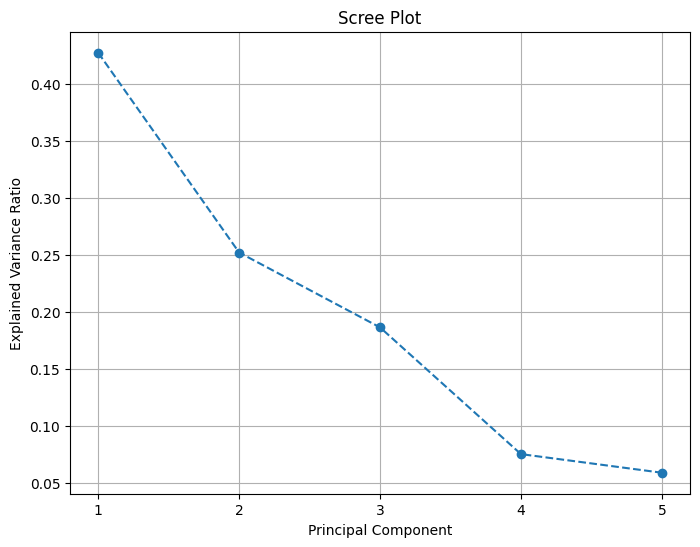

In [38]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: Select the features for PCA
# We will use the df_rf_selected dataset, which includes the top 5 features based on Random Forest importance
X_selected = df_rf_selected.drop(columns=['Species_encoded'])  # Drop target column

# Step 2: Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# Step 3: Apply PCA to the scaled data
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Step 4: Create a scree plot to show the explained variance of each component
explained_variance = pca.explained_variance_ratio_

# Plotting the scree plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid(True)

plt.savefig('screeplot.png')
# Step 5: Decide how many components to select based on the scree plot
# Typically, you want to select components that explain at least 80-90% of the variance
cumulative_variance = np.cumsum(explained_variance)

# You can select the number of components based on your desired threshold (e.g., 90%)
n_components = np.argmax(cumulative_variance >= 0.90) + 1  # +1 because index starts from 0

mlflow.set_experiment("Experiment-5")

with mlflow.start_run():
    mlflow.log_artifact('screeplot.png')

# Experiment 6 :- SVC

In [39]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Prepare the features and target
X = df_rf_selected.drop(columns=['Species_encoded'])
y = df_rf_selected['Species_encoded']

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 3: Apply PCA for dimensionality reduction (retaining 90% of variance)
pca = PCA(n_components=4)  # Based on your previous PCA output
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Step 4: Train SVM classifier using the PCA-reduced features
svm_pca = SVC(kernel='linear', random_state=42)  # You can use other kernels like 'rbf' or 'poly' as well
svm_pca.fit(X_train_pca, y_train)

# Predictions using the PCA features
y_pred_pca = svm_pca.predict(X_test_pca)

# Accuracy of the SVM classifier
accuracy_pca = accuracy_score(y_test, y_pred_pca)
f1_pca = f1_score(y_test, y_pred_pca, average='weighted')
conf_matrix_pca = confusion_matrix(y_test, y_pred_pca)

for i in range(3):
    TP = conf_matrix_pca[i, i]  # True Positives (diagonal element)
    
    # False Positives (sum of column - TP)
    FP = conf_matrix_pca[:, i].sum() - TP
    
    # False Negatives (sum of row - TP)
    FN = conf_matrix_pca[i, :].sum() - TP
    
    # True Negatives (sum of all elements except row and column of class i)
    TN = conf_matrix_pca.sum() - (TP + FP + FN)

mlflow.set_experiment('Experiment-6')

# Log F1 score and Accuracy
with mlflow.start_run():
    # Log model parameters
    mlflow.log_param("model", "SVC")
    mlflow.log_param("random_state", 42)

    # Log metrics
    mlflow.log_metric("accuracy", accuracy_pca)
    mlflow.log_metric("f1_score", f1_pca)
    mlflow.log_metric("TP", TP)
    mlflow.log_metric("TN", TN)
    mlflow.log_metric("FN", FN)
    mlflow.log_metric("FP", FP)

    # Log Confusion Matrix    
    mlflow.log_param("confusion_matrix", conf_matrix_pca.tolist())

🏃 View run big-kit-732 at: https://dagshub.com/Vedclove/EAS-Iris.mlflow/#/experiments/7/runs/7eb91417beff4028a1f12b5c16bb1709
🧪 View experiment at: https://dagshub.com/Vedclove/EAS-Iris.mlflow/#/experiments/7


# Experiment 7

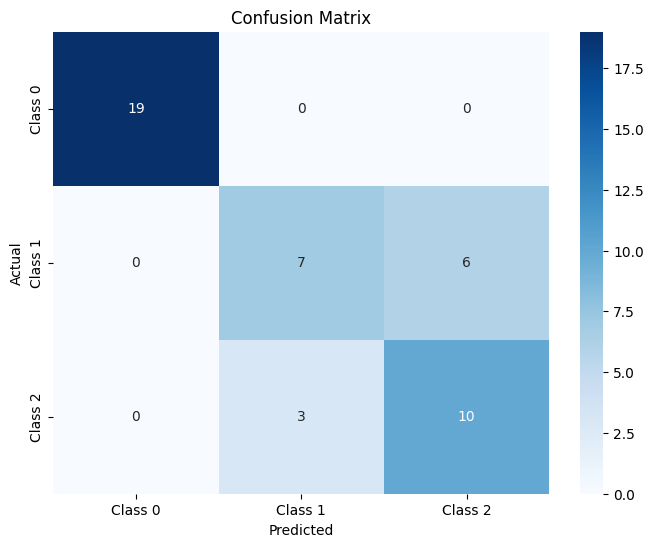

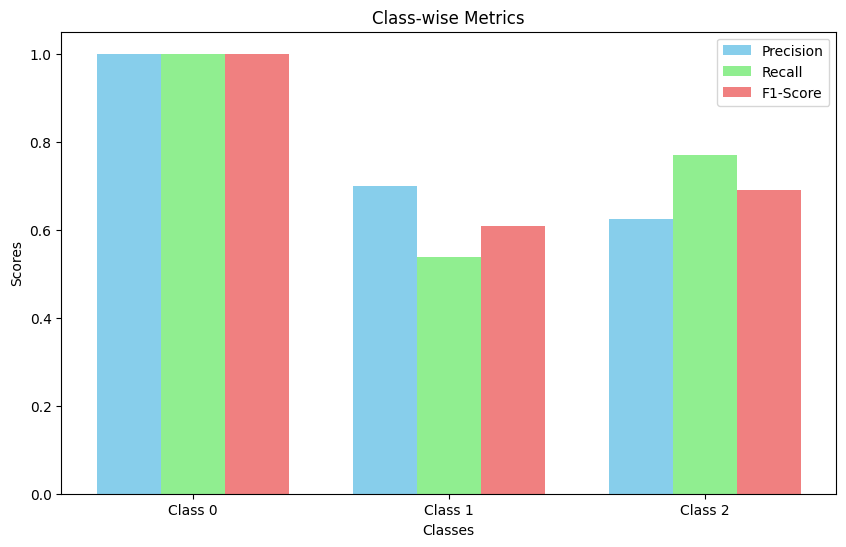

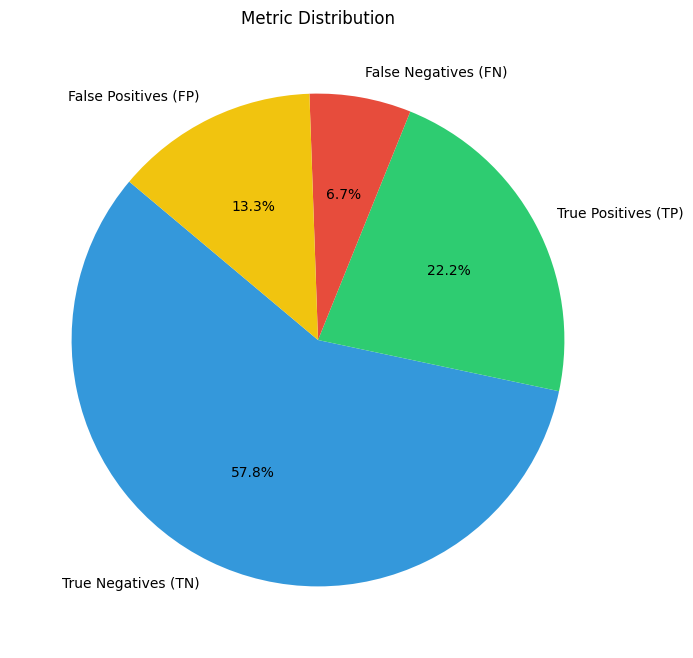

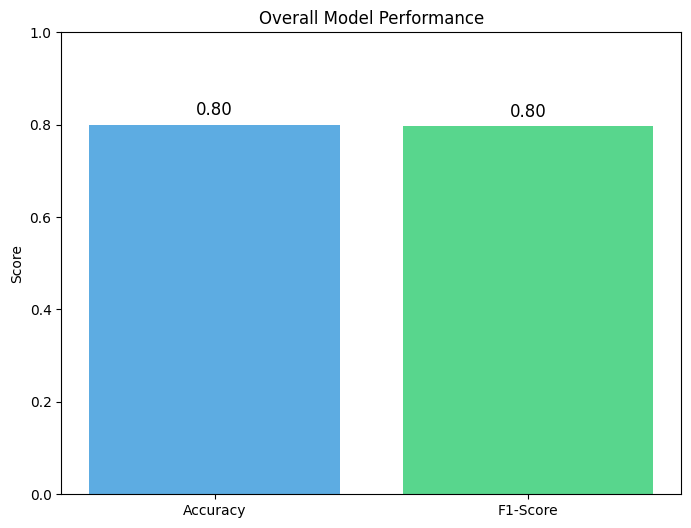

🏃 View run intrigued-snake-557 at: https://dagshub.com/Vedclove/EAS-Iris.mlflow/#/experiments/8/runs/641264a83149478285cddb0efc1fbb99
🧪 View experiment at: https://dagshub.com/Vedclove/EAS-Iris.mlflow/#/experiments/8


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data from output
conf_matrix_pca = np.array([[19, 0, 0], [0, 7, 6], [0, 3, 10]])
accuracy_pca = 0.8
f1_pca = 0.7973013493253375
metrics = {
    "TN": 26,
    "TP": 10,
    "FN": 3,
    "FP": 6
}
class_names = ["Class 0", "Class 1", "Class 2"]  # Replace with actual class labels if available

# 1. Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_pca, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 2. Precision, Recall, and F1-Score per Class
# Compute Precision, Recall, F1-score
precision = [conf_matrix_pca[i, i] / (conf_matrix_pca[:, i].sum() + 1e-10) for i in range(len(class_names))]
recall = [conf_matrix_pca[i, i] / (conf_matrix_pca[i, :].sum() + 1e-10) for i in range(len(class_names))]
f1_scores = [2 * (precision[i] * recall[i]) / (precision[i] + recall[i] + 1e-10) for i in range(len(class_names))]

# Plot Precision, Recall, F1-score
bar_width = 0.25
x = np.arange(len(class_names))

plt.figure(figsize=(10, 6))
plt.bar(x - bar_width, precision, bar_width, label='Precision', color='skyblue')
plt.bar(x, recall, bar_width, label='Recall', color='lightgreen')
plt.bar(x + bar_width, f1_scores, bar_width, label='F1-Score', color='lightcoral')

plt.xticks(x, class_names)
plt.title("Class-wise Metrics")
plt.xlabel("Classes")
plt.ylabel("Scores")
plt.legend()
plt.show()

# 3. Metric Summary Pie Chart
plt.figure(figsize=(8, 8))
metric_names = ["True Negatives (TN)", "True Positives (TP)", "False Negatives (FN)", "False Positives (FP)"]
metric_values = [metrics["TN"], metrics["TP"], metrics["FN"], metrics["FP"]]

plt.pie(metric_values, labels=metric_names, autopct='%1.1f%%', startangle=140, colors=['#3498db', '#2ecc71', '#e74c3c', '#f1c40f'])
plt.title("Metric Distribution")
plt.show()

# 4. Overall Accuracy and F1-score
plt.figure(figsize=(8, 6))
scores = [accuracy_pca, f1_pca]
score_labels = ["Accuracy", "F1-Score"]
colors = ['#3498db', '#2ecc71']

plt.bar(score_labels, scores, color=colors, alpha=0.8)
plt.ylim(0, 1)  # Scores range between 0 and 1
plt.title("Overall Model Performance")
plt.ylabel("Score")
for i, score in enumerate(scores):
    plt.text(i, score + 0.02, f"{score:.2f}", ha='center', fontsize=12)
plt.show()

# F1-score plots

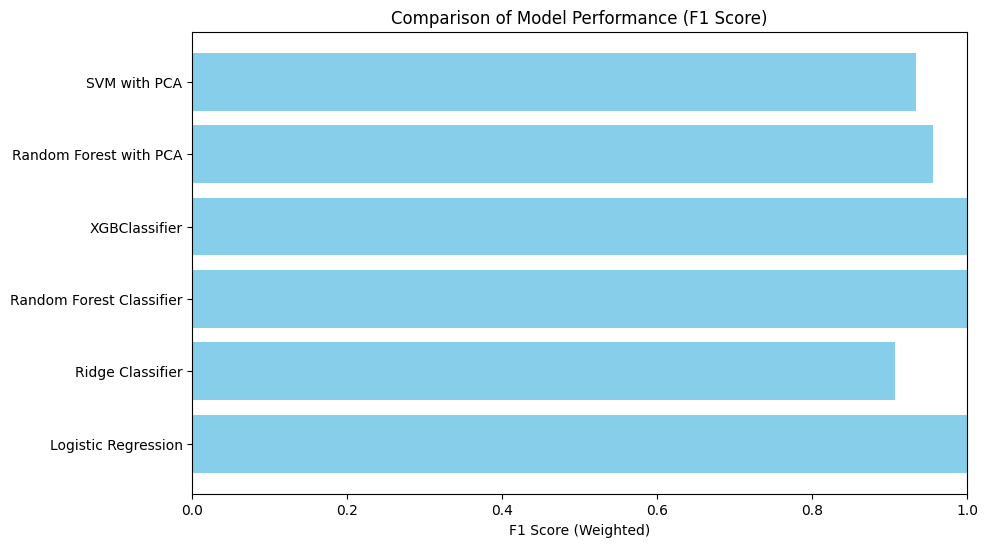

Logistic Regression: F1 Score = 1.0000
Ridge Classifier: F1 Score = 0.9065
Random Forest Classifier: F1 Score = 1.0000
XGBClassifier: F1 Score = 1.0000
Random Forest with PCA: F1 Score = 0.9556
SVM with PCA: F1 Score = 0.9333


In [41]:
import matplotlib.pyplot as plt

# Model names and corresponding F1-scores
models = [
    'Logistic Regression',
    'Ridge Classifier',
    'Random Forest Classifier',
    'XGBClassifier',
    'Random Forest with PCA',
    'SVM with PCA'
]

f1_scores = [
    1.0,  # Logistic Regression
    0.9065,  # Ridge Classifier
    1.0,  # Random Forest Classifier
    1.0,  # XGBClassifier
    0.9556,  # Random Forest with PCA
    0.9333  # SVM with PCA
]

# Create a bar plot to compare the F1-scores of each model
plt.figure(figsize=(10, 6))
plt.barh(models, f1_scores, color='skyblue')
plt.xlabel('F1 Score (Weighted)')
plt.title('Comparison of Model Performance (F1 Score)')
plt.xlim(0, 1)  # Set the x-axis to range from 0 to 1
plt.show()

# Print the F1 scores for reference
for model, score in zip(models, f1_scores):
    print(f'{model}: F1 Score = {score:.4f}')


:::{iframe} https://drive.google.com/file/d/1nks62_v5IY-l1WRHCSzi4UmyZss8yZ25/view?usp=sharing
:width: 100%
:height: 600px
:::


# Saving model

In [42]:
import joblib

# using best_model
joblib.dump(best_model, 'Iris.pkl')


['Iris.pkl']